Dataset Shape: (10000, 20)
   Claim_ID  Customer_Age Customer_Gender Policy_Type  Policy_Tenure  \
0         1            56          Female        Home             13   
1         2            69          Female        Life              8   
2         3            46            Male      Health             13   
3         4            32            Male        Home             16   
4         5            60            Male        Auto              2   

   Premium_Amount  Claim_Amount        Claim_Type  Claim_Duration_Days  \
0           22077          9095           Medical                  351   
1           15257         48385  Natural Disaster                  150   
2           49560         51295           Medical                  236   
3            8665         23277             Theft                  351   
4           40442         90261  Natural Disaster                  168   

   Num_Previous_Claims Hospital_Network  Vehicle_Age Vehicle_Type  \
0                    3    

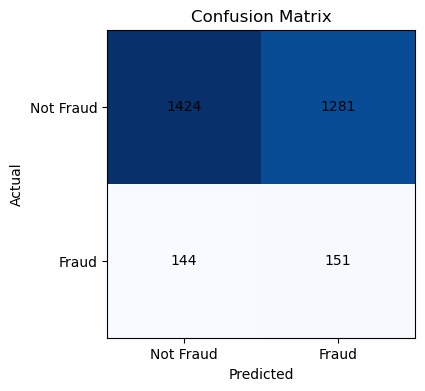

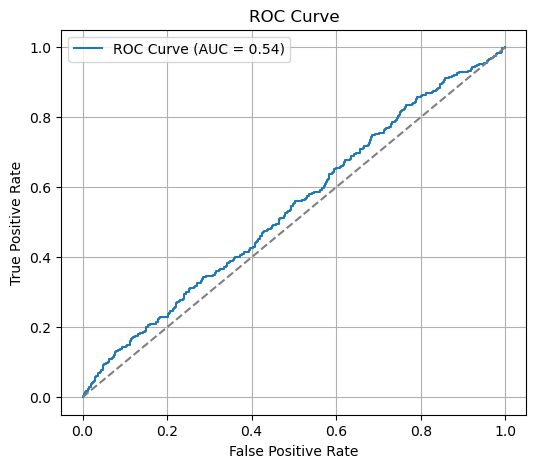


Model saved as fraud_detection_pipeline.joblib


In [3]:
# ------------------------------
# Insurance Fraud Detection Project
# ------------------------------
# Author: Kamalesh U (Fresher Project)
# Goal: Detect fraudulent claims (1) vs non-fraud (0)
# ------------------------------

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

# 2. Load Dataset
df = pd.read_csv("C:/Users/kamle/Downloads/insurance_fraud_claims.csv")

print("Dataset Shape:", df.shape)
print(df.head())

# Target distribution
print("\nTarget distribution:")
print(df['Fraudulent'].value_counts())

# 3. Drop unnecessary ID column
if 'Claim_ID' in df.columns:
    df = df.drop(columns=['Claim_ID'])

# 4. Separate features (X) and target (y)
X = df.drop(columns=['Fraudulent'])
y = df['Fraudulent']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("\nNumeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# 5. Preprocessing Pipelines
# - Numeric: impute (if needed) + scale
# - Categorical: impute (if needed) + one-hot encode
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# 6. Build Pipeline with Logistic Regression
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))  # balanced helps with class imbalance
])

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("\nTrain Shape:", X_train.shape, "Test Shape:", X_test.shape)

# 8. Fit Model
clf.fit(X_train, y_train)

# 9. Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 10. Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\n✅ Model Evaluation Results:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# 11. Plot Confusion Matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Not Fraud", "Fraud"])
plt.yticks([0,1], ["Not Fraud", "Fraud"])
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()

# 12. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 13. Save the model (optional)
import joblib
joblib.dump(clf, "fraud_detection_pipeline.joblib")
print("\nModel saved as fraud_detection_pipeline.joblib")
